<a href="https://colab.research.google.com/github/TanDuong986/Detect_Order/blob/master/Tan_workspace_RVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt


In [2]:
# !pip install ipython-autotime
# %load_ext autotime

In [3]:
thr_down_cnt = 70000 #min contour area to detect an object
thr_max_cnt = 200000 #max contour area to detect overlap object
max_contour_grab = 8
kernel = np.ones((3, 3), np.uint8)
min_dist = 60

In [4]:
def find_mask(cnts,hierarchy,close):
    # clse decide offset for object, if True, take contour closer, False is more smooth, (survey again about accurate)
    hierarchy = hierarchy[0]
    area = np.array([cv2.contourArea(c) for c in cnts]).reshape(-1,1)
    mask1 = np.where((area > thr_down_cnt) & (area <thr_max_cnt))[0]
    last = np.array([sub[-1] for sub in hierarchy])
    if close:
        mask2 = np.where(last != 1)[0]
    else:
        mask2 = np.where(last == 1)[0]
    mask = np.intersect1d(mask1,mask2)
    return mask

def gen_thresh(img,cnts,hierarchy,close=True): #input is image and raw contour find from threshold
    mask = find_mask(cnts,hierarchy,close)
    out = np.zeros_like(img)
    cnts= [cnts[i] for i in mask]
    cv2.drawContours(out,cnts,-1,(255,255,255),-1)
    return out

<function matplotlib.pyplot.show(*args, **kw)>

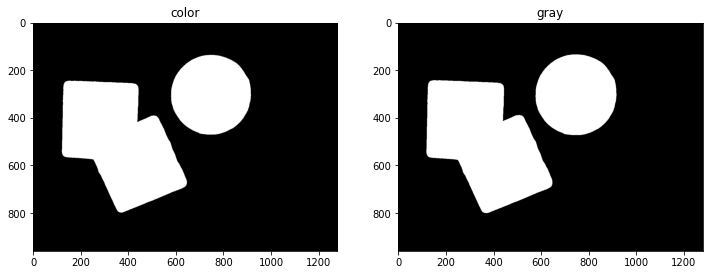

In [ ]:
im= cv2.erode(rs,None,iterations=1)
im = cv2.dilate(im,None,iterations=3)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(rs[:,:,::-1])
plt.title("color")
plt.subplot(1,2,2)
plt.imshow(im, cmap='gray')
plt.title("gray")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

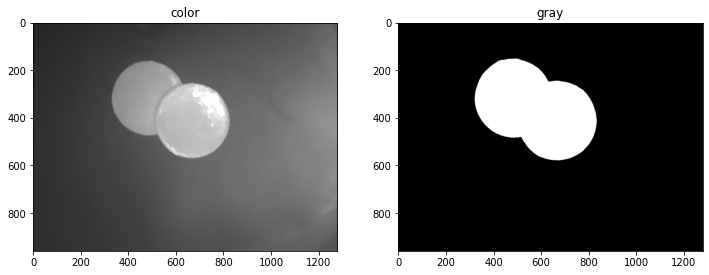

In [6]:

img_name = "/content/Image00022.BMP"
img = cv2.imread(img_name)

use = img.copy()
use = cv2.medianBlur(use,11)
use = cv2.pyrMeanShiftFiltering(use, 10,20)
gray = use[...,0]
thr = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,3)
cnts,hierarchy = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
rs = gen_thresh(use,cnts,hierarchy,False)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(use[:,:,::-1])
plt.title("color")
plt.subplot(1,2,2)
plt.imshow(rs, cmap='gray')
plt.title("gray")
plt.show


In [7]:
# edged = cv2.Canny(closing, 30, 200) #test to take threshold for overlap contour
# contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# t = shifted.copy()
# cv2.drawContours(t, contours, -1, (0, 255, 0), 3)
# plt.imshow(cv2.cvtColor(t,cv2.COLOR_BGR2RGB))
# for c in contours:
#   print(cv2.contourArea(c))

def check_overlap(thresh,C = 14000 ):
  edged = cv2.Canny(thresh, 30, 200)
  cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  return cv2.contourArea(c) > C

def find_csd(ctr):
  m = ctr[0][0]
  id_m =0
  for i in range(len(ctr)):
    if ctr[i][0] > m :
      m = ctr[i][0]
      id_m = i
  return id_m

def find_order(shifted,ctr,index):
  offset = -60
  d = (np.sqrt(2)/2)*ctr[index][2]
  tl = (int(ctr[index][0]-d-offset),int(ctr[index][1]-d-offset))
  rb = (int(ctr[index][0]+d+offset),int(ctr[index][1]+d+offset))

  consider = shifted[tl[1]:rb[1],tl[0]:rb[0]]
  consider = cv2.GaussianBlur(consider,(7,7),None)
  cny =cv2.Canny(consider[...,0],20,100)
  plt.imshow(consider,cmap='gray')
  # print(tl,rb)
  ctt, hierarchy = cv2.findContours(cny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return (len(ctt) == 0) #return True when consider lying on top


<ipython-input-9-fb36a9ab0c46>:3: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance = min_dist, labels=closing) # find each local maximum (center)
/usr/local/lib/python3.8/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


[INFO] 2 unique segments found


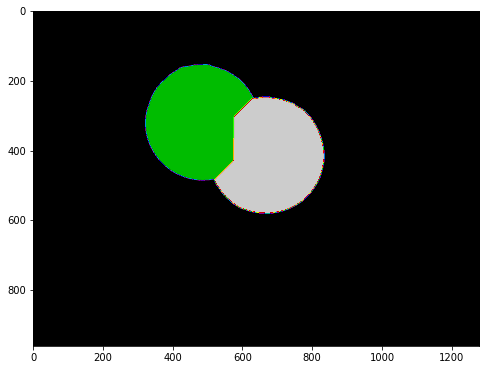

In [9]:
closing =   rs[...,0]
D = ndimage.distance_transform_edt(closing)  # compute matrix distance to correlate peak
localMax = peak_local_max(D, indices=False, min_distance = min_dist, labels=closing) # find each local maximum (center)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0] #use to make connect between pixel and label to object
labels = watershed(-D, markers, mask=closing)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
plt.figure(figsize=(8,12))
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

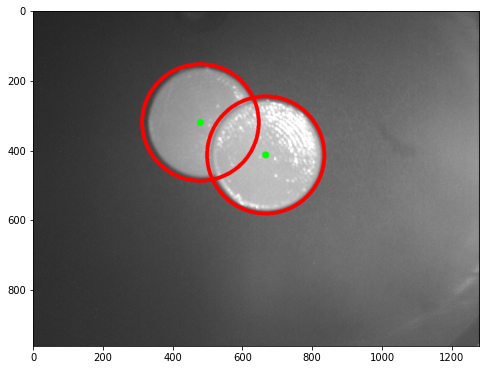

In [10]:
# loop over the unique labels returned by the Watershed
dp = img.copy()
ctr = []
# algorithm
for label in np.unique(labels):
  # if the label is zero, we are examining the 'background'
  # so simply ignore it
  if label == 0:
    continue
  # otherwise, allocate memory for the label region and draw
  # it on the mask
  mask = np.zeros(closing.shape, dtype="uint8")
  mask[labels == label] = 255
  # detect contours in the mask and grab the largest one
  cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # draw a circle enclosing the object
  ((x, y), r) = cv2.minEnclosingCircle(c)
  ctr.append((x,y,r))
  cv2.circle(dp, (int(x), int(y)), 10, (0, 255, 0), -1)
  cv2.circle(dp,(int(x), int(y)),int(r),(0, 0, 255),10)
  # cv2.rectangle(dp,(int(x-r), int(y-r)),(int(x+r), int(y+r)),(0,255,0),1)
  # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(dp,cv2.COLOR_BGR2RGB))

In [11]:
print(len(ctr))

2


In [12]:
# # HIEN THI THU TU CO DANH MAU 

# index = find_csd(ctr)
# if check_overlap(closing):

#   od = find_order(labels,ctr,index)
#   order = [0,0]
#   order[index] = od
#   order[-1-index] = not(od)
#   dpp = img.copy()
#   for i in range(2) :
#     if order[i] == True:
#       cv2.circle(dpp, (int(ctr[i][0]), int(ctr[i][1])), 10, (0, 255, 0), -1)
#       cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,255,0),12)
#       cv2.putText(dpp,"up" , (int(ctr[i][0]) + 10, int(ctr[i][1])+80),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 5)
#     else:
#       cv2.circle(dpp, (int(ctr[i][0]), int(ctr[i][1])), 10, (0, 0, 255), -1)
#       cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,0,255),12)
#       cv2.putText(dpp,"down" , (int(ctr[i][0]) + 10, int(ctr[i][1])-70),cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 12)
#   plt.figure(figsize = (8,12))
#   plt.imshow(cv2.cvtColor(dpp,cv2.COLOR_BGR2RGB))

In [13]:
# HIEN THI TOA DO CUA VAT RA TOA DO THUC TE 


# img = cv2.imread(sp_path)
# if check_overlap(closing):
#   dpp = img.copy()
#   new_ct = []
#   for i in range(2) :
#     n_x = int(ctr[i][0]+ start_point[0])
#     n_y = int(ctr[i][1]+ start_point[1])
#     new_ct.append((n_x,n_y))
#     if order[i] == True:
#       cv2.circle(dpp, (n_x, n_y), 10, (0, 255, 0), -1)
#       # cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,255,0),4)
#       cv2.putText(dpp,str(n_x)+","+str(n_y) , (n_x, n_y),cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 6)
#     else:
#       cv2.circle(dpp, (n_x, n_y), 10, (0, 0, 255), -1)
#       # cv2.rectangle(dpp,(int(ctr[i][0]-ctr[i][2]), int(ctr[i][1]-ctr[i][2])),(int(ctr[i][0]+ctr[i][2]), int(ctr[i][1]+ctr[i][2])),(0,0,255),4)
#       cv2.putText(dpp,str(n_x)+","+str(n_y) , (n_x, n_y),cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 6)
#   plt.figure(figsize = (8,12))
#   cv2.imwrite(img_name,dpp)
#   plt.imshow(cv2.cvtColor(dpp,cv2.COLOR_BGR2RGB))